In [1]:
# !pip install git+https://github.com/svsamsonov/ex2mcmc_new@master
# %cd
# !git clone https://github.com/svsamsonov/ex2mcmc_new
# %cd ex2mcmc_new

In [2]:
import subprocess
from pathlib import Path
import numpy as np
import ruamel.yaml as yaml
import torch
from easydict import EasyDict as edict
from torchvision.utils import make_grid, save_image
# from matplotlib import pyplot as plt
from PIL import Image
from tqdm import trange

import ex2mcmc
from ex2mcmc import utils
PROJECT_PATH = '.'
ex2mcmc.utils.general_utils.PROJECT_PATH = '.'
ex2mcmc.utils.general_utils.CHECKPOINT_DIR = Path(PROJECT_PATH, "checkpoints")
ex2mcmc.utils.general_utils.LOG_DIR = Path(PROJECT_PATH, "log")
ex2mcmc.utils.general_utils.IMGS_DIR = Path(PROJECT_PATH, "imgs")

from ex2mcmc.utils.general_utils import PROJECT_PATH, CHECKPOINT_DIR, LOG_DIR

from ex2mcmc.gan_distribution import Distribution, DistributionRegistry
# from ex2mcmc.models.rnvp_minimal import MinimalRNVP
from ex2mcmc.models.rnvp import RNVP
from ex2mcmc.models.utils import GANWrapper
from ex2mcmc.sample import Sampler
from ex2mcmc.utils.callbacks import CallbackRegistry
from ex2mcmc.utils.general_utils import DotConfig



2023-04-20 15:56:08.373291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
!mkdir -p checkpoints/CIFAR10/SNGAN_Hinge &  gdown 118zC_iEkN27jGLVNmDuQpMeyw7BKOUra -O checkpoints/CIFAR10/SNGAN_Hinge/netG.pth
!mkdir -p checkpoints/CIFAR10/SNGAN_Hinge &  gdown 1xU5FV59TLhAlkFubJGmJVS87HnZZ2xHT -O checkpoints/CIFAR10/SNGAN_Hinge/netD.pth

Downloading...
From: https://drive.google.com/uc?id=118zC_iEkN27jGLVNmDuQpMeyw7BKOUra
To: /root/ex2mcmc_new/checkpoints/CIFAR10/SNGAN_Hinge/netG.pth
100% 51.4M/51.4M [00:00<00:00, 132MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1xU5FV59TLhAlkFubJGmJVS87HnZZ2xHT
To: /root/ex2mcmc_new/checkpoints/CIFAR10/SNGAN_Hinge/netD.pth
100% 12.7M/12.7M [00:00<00:00, 149MB/s]


In [4]:
def define_sampler(
    config: DotConfig,
    gan: GANWrapper,
    ref_dist: Distribution,
    save_dir: Path,
):
    sampler_callbacks = []
    callbacks = config.callbacks.sampler_callbacks
    if callbacks:
        for _, callback in callbacks.items():
            params = callback.params.dict
            # HACK
            if "save_dir" in params:
                params["save_dir"] = save_dir
            sampler_callbacks.append(CallbackRegistry.create(callback.name, **params))
    sampler = Sampler(
        gan.gen,
        ref_dist,
        **config.sample_params.params,
        callbacks=sampler_callbacks,
    )

    return sampler


In [5]:
args = edict()

method = 'flex2mcmc'

configs = [f'configs/mcmc_configs/{method}.yml', 'configs/mmc_sngan.yml']
configs = [Path(PROJECT_PATH, x).as_posix() for x in configs]
args.configs = configs

proc = subprocess.Popen("/bin/bash", stdin=subprocess.PIPE, stdout=subprocess.PIPE)
out, err = proc.communicate(
        ("cat - " + " ".join([f"{conf} <(echo)" for conf in args.configs])).encode(
            "utf-8"
        )
    )
config = yaml.round_trip_load(out.decode("utf-8"))
config = DotConfig(config)

In [6]:
config.sample_params['total_n'] = 5
config.sample_params['batch_size'] = 5
config.sample_params.params['n_steps'] = 150
config.sample_params.params['save_every'] = 4

In [7]:
device = torch.device(config.device if torch.cuda.is_available() else "cpu")

gan = GANWrapper(config.gan_config, device)
ref_dist = DistributionRegistry.create(
    config.sample_params.distribution.name, gan=gan
)

Transform: Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])


In [8]:
config.device

'cuda'

In [9]:
save_dir = Path('log', 'tutorial')
save_dir.mkdir(exist_ok=True, parents=True)

sampler = define_sampler(config, gan, ref_dist, save_dir)

In [10]:
start_latents = gan.prior.sample((config.sample_params.total_n,)).cpu()
start_step_id = 0
labels = torch.LongTensor(
    np.random.randint(
        0,
        9, #dataset_info.get("n_classes", 10) - 1,
        config.sample_params.total_n,
    )
)

In [11]:
if config.get("flow", None):
    gan.gen.proposal = RNVP(4, gan.gen.z_dim, device=device)
    opt = torch.optim.Adam(gan.gen.proposal.parameters(), 1e-3)
    for _ in trange(1000):
        e = -gan.gen.proposal.log_prob(
            gan.gen.prior.sample((config.batch_size,))
        ).mean()
        gan.gen.proposal.zero_grad()
        e.backward()
        opt.step()
    opt = torch.optim.Adam(
        gan.gen.proposal.parameters(), **config.flow.opt_params
    )
    gan.gen.proposal.optim = opt
    gan.gen.proposal.train()
    gan.gen.proposal.scheduler = torch.optim.lr_scheduler.LambdaLR(
        opt, lambda it: int(it < config.flow.train_iters)
    )
else:
    gan.gen.proposal = gan.gen.prior

start = start_latents.to(device)
label = labels.to(device)
gan.set_label(label)

zs, xs = sampler(start)
sampler.reset()
gan.gen.input = gan.gen.output = gan.dis.input = gan.dis.output = None

zs = torch.stack(zs, 0).cpu()
xs = torch.stack(xs, 0).cpu()
print(zs.shape[:-1])


  1%|          | 1/150 [00:00<00:50,  2.93it/s]

KL forw 182.273,                     KL back 1.552 


  1%|▏         | 2/150 [00:00<00:42,  3.51it/s]

KL forw 179.501,                     KL back 1.125 


  2%|▏         | 3/150 [00:00<00:40,  3.64it/s]

KL forw 179.835,                     KL back 1.380 


  3%|▎         | 4/150 [00:01<00:40,  3.63it/s]

KL forw 181.212,                     KL back 1.234 


  3%|▎         | 5/150 [00:01<00:39,  3.67it/s]

KL forw 181.619,                     KL back 1.137 


  4%|▍         | 6/150 [00:01<00:39,  3.64it/s]

KL forw 181.634,                     KL back 1.514 


  5%|▍         | 7/150 [00:01<00:38,  3.70it/s]

KL forw 182.318,                     KL back 1.511 


  5%|▌         | 8/150 [00:02<00:38,  3.69it/s]

KL forw 181.807,                     KL back 1.511 


  6%|▌         | 9/150 [00:02<00:37,  3.73it/s]

KL forw 184.020,                     KL back 1.870 


  7%|▋         | 10/150 [00:02<00:37,  3.73it/s]

KL forw 182.079,                     KL back 2.210 


  7%|▋         | 11/150 [00:03<00:38,  3.64it/s]

KL forw 180.434,                     KL back 2.258 


  8%|▊         | 12/150 [00:03<00:38,  3.56it/s]

KL forw 183.669,                     KL back 1.752 


  9%|▊         | 13/150 [00:03<00:36,  3.72it/s]

KL forw 183.687,                     KL back 2.389 


  9%|▉         | 14/150 [00:03<00:36,  3.78it/s]

KL forw 179.754,                     KL back 3.158 


 10%|█         | 15/150 [00:04<00:34,  3.90it/s]

KL forw 175.432,                     KL back 3.314 


 11%|█         | 16/150 [00:04<00:33,  3.95it/s]

KL forw 175.914,                     KL back 3.273 


 11%|█▏        | 17/150 [00:04<00:33,  4.02it/s]

KL forw 178.311,                     KL back 3.442 


 12%|█▏        | 18/150 [00:04<00:32,  4.04it/s]

KL forw 183.313,                     KL back 3.661 


 13%|█▎        | 19/150 [00:05<00:32,  4.07it/s]

KL forw 182.165,                     KL back 3.733 


 13%|█▎        | 20/150 [00:05<00:32,  4.05it/s]

KL forw 185.864,                     KL back 4.411 


 14%|█▍        | 21/150 [00:05<00:31,  4.11it/s]

KL forw 187.079,                     KL back 4.163 


 15%|█▍        | 22/150 [00:05<00:31,  4.09it/s]

KL forw 182.171,                     KL back 4.431 


 15%|█▌        | 23/150 [00:05<00:31,  4.09it/s]

KL forw 181.086,                     KL back 4.424 


 16%|█▌        | 24/150 [00:06<00:31,  4.06it/s]

KL forw 179.270,                     KL back 3.435 


 17%|█▋        | 25/150 [00:06<00:30,  4.11it/s]

KL forw 178.345,                     KL back 4.163 


 17%|█▋        | 26/150 [00:06<00:30,  4.06it/s]

KL forw 179.586,                     KL back 4.596 


 18%|█▊        | 27/150 [00:06<00:30,  4.10it/s]

KL forw 183.432,                     KL back 4.119 


 19%|█▊        | 28/150 [00:07<00:29,  4.13it/s]

KL forw 186.624,                     KL back 4.632 


 19%|█▉        | 29/150 [00:07<00:28,  4.17it/s]

KL forw 181.089,                     KL back 4.428 


 20%|██        | 30/150 [00:07<00:28,  4.18it/s]

KL forw 179.042,                     KL back 4.657 


 21%|██        | 31/150 [00:07<00:28,  4.21it/s]

KL forw 179.470,                     KL back 4.709 


 21%|██▏       | 32/150 [00:08<00:28,  4.15it/s]

KL forw 186.084,                     KL back 4.058 


 22%|██▏       | 33/150 [00:08<00:28,  4.17it/s]

KL forw 187.020,                     KL back 4.967 


 23%|██▎       | 34/150 [00:08<00:27,  4.15it/s]

KL forw 187.499,                     KL back 3.889 


 23%|██▎       | 35/150 [00:08<00:27,  4.13it/s]

KL forw 185.899,                     KL back 3.713 


 24%|██▍       | 36/150 [00:09<00:27,  4.10it/s]

KL forw 181.899,                     KL back 3.655 


 25%|██▍       | 37/150 [00:09<00:27,  4.13it/s]

KL forw 183.507,                     KL back 3.740 


 25%|██▌       | 38/150 [00:09<00:27,  4.13it/s]

KL forw 182.254,                     KL back 3.908 


 26%|██▌       | 39/150 [00:09<00:26,  4.12it/s]

KL forw 179.669,                     KL back 3.305 


 27%|██▋       | 40/150 [00:10<00:26,  4.13it/s]

KL forw 188.034,                     KL back 3.668 


 27%|██▋       | 41/150 [00:10<00:26,  4.15it/s]

KL forw 184.627,                     KL back 3.884 


 28%|██▊       | 42/150 [00:10<00:26,  4.14it/s]

KL forw 186.176,                     KL back 3.783 


 29%|██▊       | 43/150 [00:10<00:26,  4.08it/s]

KL forw 185.849,                     KL back 3.296 


 29%|██▉       | 44/150 [00:11<00:26,  4.02it/s]

KL forw 179.744,                     KL back 3.218 


 30%|███       | 45/150 [00:11<00:25,  4.07it/s]

KL forw 177.281,                     KL back 3.240 


 31%|███       | 46/150 [00:11<00:25,  4.07it/s]

KL forw 176.954,                     KL back 2.766 


 31%|███▏      | 47/150 [00:11<00:25,  4.07it/s]

KL forw 178.492,                     KL back 3.979 


 32%|███▏      | 48/150 [00:12<00:25,  4.05it/s]

KL forw 177.922,                     KL back 3.799 


 33%|███▎      | 49/150 [00:12<00:24,  4.09it/s]

KL forw 183.690,                     KL back 3.481 


 33%|███▎      | 50/150 [00:12<00:24,  4.09it/s]

KL forw 182.952,                     KL back 3.381 


 34%|███▍      | 51/150 [00:12<00:24,  4.10it/s]

KL forw 183.757,                     KL back 3.325 


 35%|███▍      | 52/150 [00:13<00:23,  4.09it/s]

KL forw 184.490,                     KL back 3.806 


 35%|███▌      | 53/150 [00:13<00:23,  4.14it/s]

KL forw 180.334,                     KL back 3.798 


 36%|███▌      | 54/150 [00:13<00:23,  4.04it/s]

KL forw 178.158,                     KL back 3.420 


 37%|███▋      | 55/150 [00:13<00:24,  3.91it/s]

KL forw 177.672,                     KL back 3.582 


 37%|███▋      | 56/150 [00:14<00:24,  3.89it/s]

KL forw 179.843,                     KL back 3.097 


 38%|███▊      | 57/150 [00:14<00:24,  3.83it/s]

KL forw 183.630,                     KL back 3.925 


 39%|███▊      | 58/150 [00:14<00:24,  3.83it/s]

KL forw 189.255,                     KL back 3.128 


 39%|███▉      | 59/150 [00:14<00:24,  3.74it/s]

KL forw 192.375,                     KL back 3.977 


 40%|████      | 60/150 [00:15<00:24,  3.70it/s]

KL forw 187.021,                     KL back 3.921 


 41%|████      | 61/150 [00:15<00:24,  3.68it/s]

KL forw 188.101,                     KL back 3.361 


 41%|████▏     | 62/150 [00:15<00:23,  3.67it/s]

KL forw 187.938,                     KL back 3.219 


 42%|████▏     | 63/150 [00:15<00:23,  3.67it/s]

KL forw 187.201,                     KL back 3.707 


 43%|████▎     | 64/150 [00:16<00:22,  3.76it/s]

KL forw 183.776,                     KL back 3.608 


 43%|████▎     | 65/150 [00:16<00:21,  3.87it/s]

KL forw 183.101,                     KL back 2.842 


 44%|████▍     | 66/150 [00:16<00:21,  3.95it/s]

KL forw 181.089,                     KL back 3.212 


 45%|████▍     | 67/150 [00:16<00:20,  3.97it/s]

KL forw 182.455,                     KL back 3.645 


 45%|████▌     | 68/150 [00:17<00:20,  3.97it/s]

KL forw 180.766,                     KL back 3.134 


 46%|████▌     | 69/150 [00:17<00:20,  4.02it/s]

KL forw 181.208,                     KL back 2.987 


 47%|████▋     | 70/150 [00:17<00:19,  4.05it/s]

KL forw 178.820,                     KL back 3.704 


 47%|████▋     | 71/150 [00:17<00:19,  4.07it/s]

KL forw 180.966,                     KL back 3.514 


 48%|████▊     | 72/150 [00:18<00:19,  4.10it/s]

KL forw 180.096,                     KL back 3.315 


 49%|████▊     | 73/150 [00:18<00:18,  4.14it/s]

KL forw 173.230,                     KL back 3.855 


 49%|████▉     | 74/150 [00:18<00:18,  4.17it/s]

KL forw 177.499,                     KL back 3.070 


 50%|█████     | 75/150 [00:18<00:18,  4.11it/s]

KL forw 173.537,                     KL back 3.905 


 51%|█████     | 76/150 [00:19<00:18,  4.10it/s]

KL forw 181.744,                     KL back 3.205 


 51%|█████▏    | 77/150 [00:19<00:17,  4.13it/s]

KL forw 185.854,                     KL back 3.292 


 52%|█████▏    | 78/150 [00:19<00:17,  4.16it/s]

KL forw 186.025,                     KL back 3.136 


 53%|█████▎    | 79/150 [00:19<00:17,  4.15it/s]

KL forw 183.861,                     KL back 3.671 


 53%|█████▎    | 80/150 [00:20<00:17,  4.10it/s]

KL forw 188.587,                     KL back 2.959 


 54%|█████▍    | 81/150 [00:20<00:16,  4.13it/s]

KL forw 182.223,                     KL back 3.051 


 55%|█████▍    | 82/150 [00:20<00:16,  4.11it/s]

KL forw 174.869,                     KL back 3.604 


 55%|█████▌    | 83/150 [00:20<00:16,  4.11it/s]

KL forw 178.321,                     KL back 3.483 


 56%|█████▌    | 84/150 [00:21<00:16,  4.07it/s]

KL forw 182.895,                     KL back 3.999 


 57%|█████▋    | 85/150 [00:21<00:15,  4.11it/s]

KL forw 184.787,                     KL back 3.825 


 57%|█████▋    | 86/150 [00:21<00:15,  4.07it/s]

KL forw 177.184,                     KL back 3.305 


 58%|█████▊    | 87/150 [00:21<00:15,  4.08it/s]

KL forw 180.547,                     KL back 3.847 


 59%|█████▊    | 88/150 [00:22<00:15,  4.05it/s]

KL forw 176.881,                     KL back 2.919 


 59%|█████▉    | 89/150 [00:22<00:14,  4.10it/s]

KL forw 174.460,                     KL back 3.261 


 60%|██████    | 90/150 [00:22<00:14,  4.10it/s]

KL forw 174.859,                     KL back 3.920 


 61%|██████    | 91/150 [00:22<00:14,  4.11it/s]

KL forw 175.295,                     KL back 3.976 


 61%|██████▏   | 92/150 [00:23<00:14,  4.03it/s]

KL forw 181.454,                     KL back 3.680 


 62%|██████▏   | 93/150 [00:23<00:14,  4.06it/s]

KL forw 184.762,                     KL back 3.308 


 63%|██████▎   | 94/150 [00:23<00:13,  4.11it/s]

KL forw 180.910,                     KL back 4.107 


 63%|██████▎   | 95/150 [00:23<00:13,  4.10it/s]

KL forw 182.748,                     KL back 3.137 


 64%|██████▍   | 96/150 [00:24<00:13,  4.06it/s]

KL forw 187.209,                     KL back 3.976 


 65%|██████▍   | 97/150 [00:24<00:12,  4.12it/s]

KL forw 189.664,                     KL back 3.699 


 65%|██████▌   | 98/150 [00:24<00:12,  4.05it/s]

KL forw 186.769,                     KL back 4.207 


 66%|██████▌   | 99/150 [00:24<00:12,  4.09it/s]

KL forw 185.027,                     KL back 4.622 


 67%|██████▋   | 100/150 [00:25<00:12,  4.05it/s]

KL forw 178.458,                     KL back 3.570 


100%|██████████| 150/150 [00:35<00:00,  4.19it/s]

Time elapsed:  36.63s
torch.Size([38, 5])


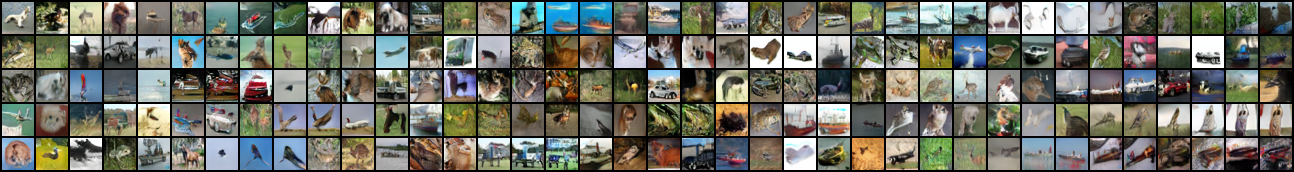

In [12]:
imgs = []
for step in range(xs.shape[0]):
    img = xs[step]
    imgs.append(img)
imgs = torch.stack(imgs, 1).view(-1, 3, 32, 32)
grid = make_grid(imgs, nrow=xs.shape[0])

grid = (255 * grid.permute(1, 2, 0).numpy()).astype('uint8')
Image.fromarray(grid)